In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

$\textbf{1-D Advection equation } $
\begin{equation}
       \partial_t u + \partial_x u = 0, 
\end{equation}

$\textbf{Algorithm 4.1 Reconstruct-evolve-average } $(Leveuqe FVM red book pg 76)
1. Reconstruct a piecewise polynomial function $\tilde{q}^n(x, t_n)$ defined for all x, from the cell
averages $Q_n$
In the simplest case this is a piecewise constant function that takes the
value $Q_n$ in the ith grid cell, i.e.,
$$\tilde{q}^n(x, t_n) = Q_i^n \text{ for all x} \in C_i$$

2. Evolve the hyperbolic equation exactly (or approximately) with this initial data to obtain
$\tilde{q}^n(x, t_{n+1})$ a time $\Delta t$ later.

3. Average this function over each grid cell to obtain new cell averages
$$Q_i^{n+1} = \frac{1}{\Delta x} \int_{C_i} \tilde{q}^n(x, t_{n+1}) dx


In [2]:


def rea(x, Q, dt, a):
    n = len(x)
    dx = x[1] - x[0]
    Q_new = np.zeros_like(Q)  # Initialize the new cell averages

    # Step 1: Reconstruct
    Q_tilde = np.copy(Q)  # Assign cell average to each grid cell

    # Step 2: Evolve
    Q_tilde_next = np.zeros_like(Q_tilde)
    for i in range(1, n-1):  # We start from 1 and end at n-1 to avoid updating the boundaries
        advection_term = a * (Q_tilde[i+1] - Q_tilde[i]) if a > 0 else a * (Q_tilde[i] - Q_tilde[i-1])
        Q_tilde_next[i] = Q_tilde[i] - dt/dx * advection_term

    # Step 3: Average
    for i in range(1, n-1):  # Again, avoid updating the boundaries
        Q_left = Q_tilde_next[i-1]
        Q_right = Q_tilde_next[i+1]
        Q_new[i] = np.mean([Q_left, Q_tilde_next[i], Q_right])

    # Step 4: Update the boundaries
    Q_new[0] = Q[0]
    Q_new[-1] = Q[-1]

    return Q_new







# Define the mesh generator
def mesh_generator_1d(x_l, x_r, n_nodes):
    h = (x_r - x_l) / (n_nodes-1)
    x_coords = np.linspace(x_l, x_r, n_nodes)
    return h, x_coords

# Define the initial condition function g(x)
def g(x):
    return np.where(x <= 0, 2, 1)

# Initialize lists to store h values and errors
h_values = []
errors = []

# Time interval
T = 0.25
 # Advection speed
c = 1

k_values = range(2,10)

# Run the function for each k value
for k in k_values:
    n_nodes = 2**k
    h, x = mesh_generator_1d(-1, 1, n_nodes)
    dt =  0.5

    # Initial 
    Q = g(x)  # Use the entire spatial grid

   

    # Number of time steps
    # num_steps = k  # Use k as the number of time steps
    num_steps = int(T/dt)#number of time steps needed

    # Apply the REA algorithm
    for _ in range(num_steps):
        Q = rea(x,Q,dt,c)  

    # Compute the exact solution at final time
    u_exact = g(x - c*T)
    # u_exact = g(x)

    # Compute the error at final time
    error = np.linalg.norm(np.abs(Q - u_exact), ord=1)

    # Store h and error
    h_values.append(h)
    errors.append(error*h)

# # Display the errors
# for i, error in enumerate(errors):
#     print(f"Error for n_nodes={2 ** k_values[i] + 1}: {error}")


# print(f'Q = {Q} \n\n exact = {g(x-T)}')

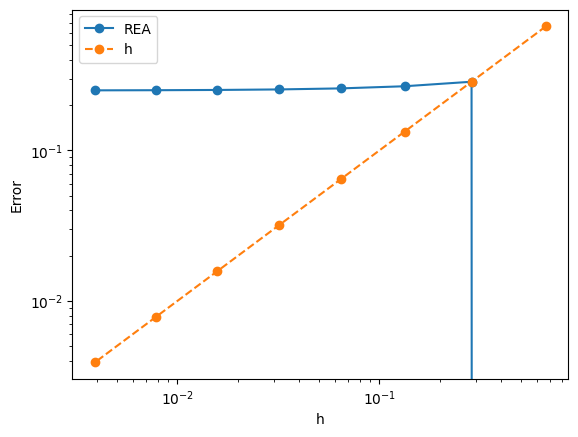

In [3]:
# Plot the convergence
plt.loglog(h_values, errors, 'o-', label='REA')
plt.loglog(h_values, h_values, '--o', label='h')
plt.xlabel('h')
plt.ylabel('Error')
plt.legend()
plt.show()

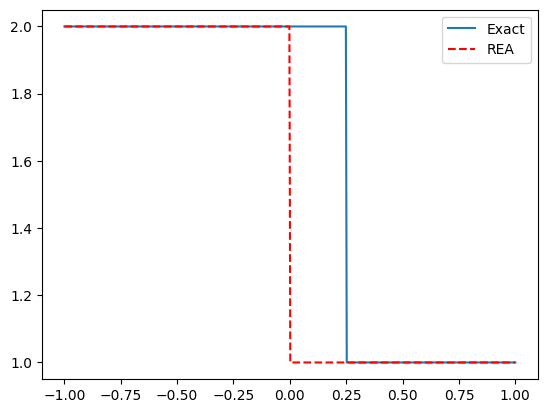

In [4]:
plt.plot(x,g(x-T),label = 'Exact')
plt.plot(x,Q,'--r', label = 'REA')
plt.legend()

Godunov flux function for convex scalar conservation law (Leveque Red p228)

$$F_{i-\frac{1}{2}}^n = \begin{cases}
    f(Q_{i-1}) & \text{if } Q_{i-1} > q_s &\text{and} &s > 0\\
    f(Q_i) & \text{if } Q_i < q_s &\text{and} &s < 0\\
    f(q_s) & \text{if } & Q_{i-1} < q_s < Q_i\\

    \end{cases}
$$

$s$ = $\frac{[f(Q_i) - f(Q_{i-1})]}{Q_i - Q_{i-1}} $

Godunov method reduced to the first-order upwind method

$$Q^{n+1}_i = Q_i - \frac{\Delta t}{\Delta x}[f(Q_i)-f(Q_{i-1})] $$

$q_s$ is the unique value of q for which $f'(q_s) = 0$


In [5]:
#Def for advection equation 
#ToDo: check sign of u, fix solve_riemann: Update to check if u_l < u_r and other conditions use Flux 

# mesh generator function
def mesh_generator_1d(x_l, x_r, n_nodes):
    h = (x_r - x_l) / (n_nodes - 1)
    x_coords = np.linspace(x_l, x_r, n_nodes)
    return h, x_coords

# initial condition function g(x)
def g(x):
    return np.where(x <= 0, 1, 2)

# exact solution function f(x, t)
def f_exact(x, t):
    return g(x - c * t)

# flux function for advection 
def flux(q):
    return c * q


def solve_riemann(ql, qr, flux):
    # c = (flux(qr) - flux(ql)) / ((qr - ql)+1e-10)
    if c > 0: # if speed is positive 
        return ql # return left state of interface 
    else:
        return qr # else return right state 

# Godunov solver function
def godunov_solver(n_nodes, T):
    
    h, x = mesh_generator_1d(x_l, x_r, n_nodes)  # Generate the mesh

    dx = h
    dt = 0.9* dx/c  # CFL condition
    N = n_nodes  # Number of nodes

    # Initialize solution array
    u = g(x)  # Initialize u with the initial condition

    # Perform Godunov's method
    t = 0
    while t < T:
        u_old = u.copy()
        for i in range(1, N - 1): # loop over interior points
            ql = u_old[i - 1] # get solution to the left
            qr = u_old[i] # get solution at the current point
            q_left = solve_riemann(ql, qr, flux) # solve riemann at left interface
            ql = u_old[i] # get solution at current point
            qr = u_old[i + 1] # get solution at the right of the point
            q_right = solve_riemann(ql, qr, flux) # Solve the riemann at the right interface
            f_left = flux(q_left) # compute left flux
            f_right = flux(q_right) # compute right flux 
            u[i] = u_old[i] - dt / dx * (f_right - f_left) # update the solution using the godunov method
            #update boundary conditions
            # u[0] = u[-2]
            u[-1] = u[1] 
        t += dt # increment time 

    return u, x


# Perform the convergence analysis
errors = []
h_val = []

T = 0.25   #final time
c = 1   #speed for advection 
x_r  = 1
x_l = -1


k_values = range(2, 7)
for k in k_values:
    n_nodes = 2 ** k + 1
    u, x  = godunov_solver(n_nodes, T)
    # Calculate the error as the 1-norm between u and the exact solution
    error = np.linalg.norm(u - f_exact(x, T), ord=1)
    h = (x_r - x_l) / (n_nodes - 1)
    errors.append(error*h)
    h_val.append(h)

# # Display the errors
# for i, error in enumerate(errors):
#     print(f"Error for n_nodes={2 ** k_values[i] + 1}: {error}")


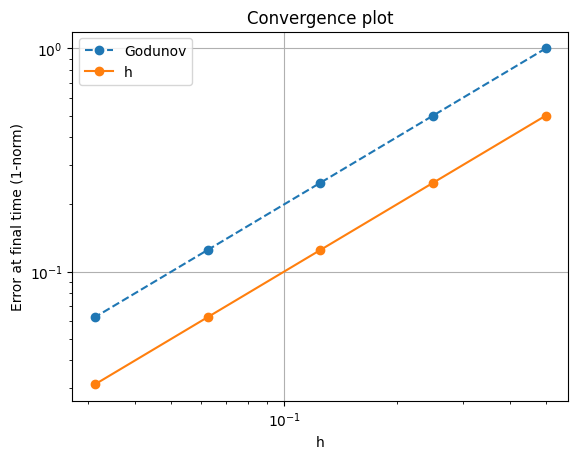

In [6]:
# Generate the convergence plot
plt.figure()
plt.loglog(h_val, errors, 'o--', label = 'Godunov')
plt.loglog(h_val, h_val, 'o-', label = 'h')

plt.xlabel('h')
plt.ylabel('Error at final time (1-norm)')
plt.title('Convergence plot')
plt.legend()
plt.grid(True)
plt.show()

Plot u and u_exact check initial data and boundary conditions and work in REA

Print one time step 
    1. if too fast issue with flux
    2. if it goesd down somthing is wrong with edges
    *keep track of where the bump is to keep track 

In [7]:
#Remove cell for final jupyter notebook

# plt.plot(x,u,label = 'Exact')
# plt.plot(x,f_exact(x, T),'--r', label = 'Godunov')
# plt.legend()

In [8]:
#Remove cell for final jupyter notebook

# print(f'u = {u} \n\n exact = {f_exact(x, T)}')

Here you seek a numerical solution of $\textbf{Burgers' equation}$

\begin{equation}
       \partial_t u + \frac{1}{2}\partial_x u^2 = 0, 
\end{equation}

in the domain $\Omega = [-1,1]$ and a time interval $[0,0.25]$. The boundary condition is $u(0,t) = 3$ and the initial condition is 
    
\begin{equation}
    u(x,0) = \left\{
    \begin{aligned}
        3, &\,\,\quad ~if \quad x<0 ,\\
        1 &\,\, \quad ~if \quad x>0.
    \end{aligned}
    \right.
\end{equation}

Given Piecewise constant initial data $u_l = 3 > 1 = u_r$  implies this is case 1 where there is a unique weak solution. Appying the Rankine-Hugoniot  condition 

$$\frac{f(u_r)-f(u_l)}{u_l - u_r} =\frac{ \frac{1}{2} 1^2 - \frac{1}{2} 3^2}{1-3} = 2 = s$$

Given s = speed of propogation we our exact solution is: 
$$ u(x, t) = \begin{cases}
    3 & \text{if } x < 2t \\
    1 & \text{if } x \geq 2t
\end{cases}
$$


Godunov's method (Hesthaven p124)
$$u_j^{n+1} = u_j^n - \frac{k}{h}[F_{j+\frac{1}{2}}^n - F_{j-\frac{1}{2}}^n]$$
The scheme is in conservation form by construction ensuring correct shock speeds. Unknown is the cell average rather than the point value as with the finite difference scheme.

Consider Burgers's equation 
$$ u_{j+\frac{1}{2}}^* =   \left\{
\begin{array}{ll}
      u_l, & s \geq 0\\
      u_r, & s < 0\\
\end{array} 
\right.  $$

$$ s = \frac{f(u_l)-f(u_r)}{u_l - u_r}$$

$$u_j^{n+1} = u_j^n - \frac{k}{h} [f(u_{j+\frac{1}{2}}^*) - f(u_{j-\frac{1}{2}}^*)] $$
$u^*$ is computed by solving the Riemann problem exactly and selecting the correct entropy solution.



Leveque Green pg. 144

In [9]:
#Def for burgers equation
#qs = 0 for burgers 


# mesh generator function
def mesh_generator_1d(x_l, x_r, n_nodes):
    h = (x_r - x_l) / (n_nodes - 1)
    x_coords = np.linspace(x_l, x_r, n_nodes)
    return h, x_coords

# initial condition function g(x)
def g(x):
    return np.where(x <= 0, 3, 1)

# exact solution function f(x, t)
def f_exact(x, t):
    return np.where(x <= 2*t, 3, 1)

# flux function for burgers
def flux(q):
    return np.power(q,2)/2




# Perform the convergence analysis
errors = []
h_val = []

T = 0.25     #final time
c = 2 #speed for burgers
x_r  = 1
x_l = -1


k_values = range(2, 10)
for k in k_values:
    n_nodes = 2 ** k + 1
    h, x = mesh_generator_1d(x_l, x_r, n_nodes)
    u, x_coords = godunov_solver(n_nodes, T)
    # Calculate the error as the 1-norm between u and the exact solution
    error = np.linalg.norm(u - f_exact(x_coords, T), ord=1)
    # h = (x_r - x_l) / (n_nodes - 1)
    errors.append(error*h)
    h_val.append(h)

# Display the errors
for i, error in enumerate(errors):
    print(f"Error for n_nodes={2 ** k_values[i] + 1}: {error}")


Error for n_nodes=5: 1.0
Error for n_nodes=9: 0.75
Error for n_nodes=17: 0.625
Error for n_nodes=33: 0.5625
Error for n_nodes=65: 0.5
Error for n_nodes=129: 0.46875
Error for n_nodes=257: 0.453125
Error for n_nodes=513: 0.44921875


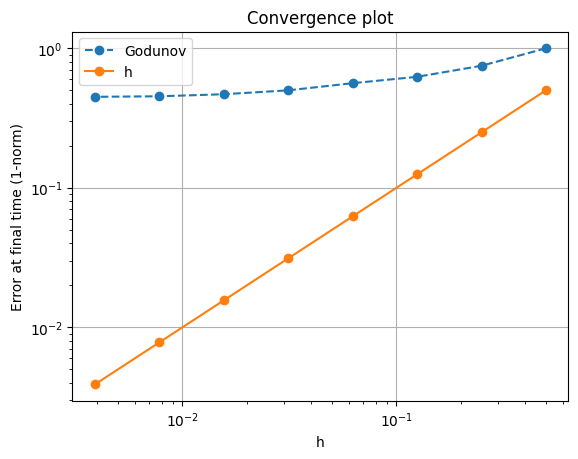

In [10]:
# Generate the convergence plot
plt.figure()
plt.loglog(h_val, errors, 'o--', label = 'Godunov')
plt.loglog(h_val, h_val, 'o-', label = 'h')

plt.xlabel('h')
plt.ylabel('Error at final time (1-norm)')
plt.title('Convergence plot')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
#Remove cell for final jupyter notebook
# plt.plot(x,f_exact(x, T), label = 'Exact')
# plt.plot(x,u,'--r', label = 'Godunov')
# plt.legend()

In [12]:
#Def for burgers equation


# mesh generator function
def mesh_generator_1d(x_l, x_r, n_nodes):
    h = (x_r - x_l) / (n_nodes - 1)
    x_coords = np.linspace(x_l, x_r, n_nodes)
    return h, x_coords

# initial condition function g(x)
def g(x):
    return np.where(x <= 0, 1, 3)

# exact solution function f(x, t)
def f_exact(x, t):
    return np.where(x <= 2*t, 1, 3)

# flux function for burgers
def flux(q):
    return np.power(q,2)/2




# Perform the convergence analysis
errors = []
h_val = []

T = 0.25     #final time
c = 2 #speed for burgers
x_r  = 1
x_l = -1


k_values = range(2, 10)
for k in k_values:
    n_nodes = 2 ** k + 1
    h, x = mesh_generator_1d(x_l, x_r, n_nodes)
    u, x_coords = godunov_solver(n_nodes, T)
    # Calculate the error as the 1-norm between u and the exact solution
    error = np.linalg.norm(u - f_exact(x_coords, T), ord=1)
    # h = (x_r - x_l) / (n_nodes - 1)
    errors.append(error*h)
    h_val.append(h)

# Display the errors
for i, error in enumerate(errors):
    print(f"Error for n_nodes={2 ** k_values[i] + 1}: {error}")


Error for n_nodes=5: 1.0
Error for n_nodes=9: 1.0
Error for n_nodes=17: 0.5
Error for n_nodes=33: 0.25
Error for n_nodes=65: 0.1875
Error for n_nodes=129: 0.15625
Error for n_nodes=257: 0.140625
Error for n_nodes=513: 0.125


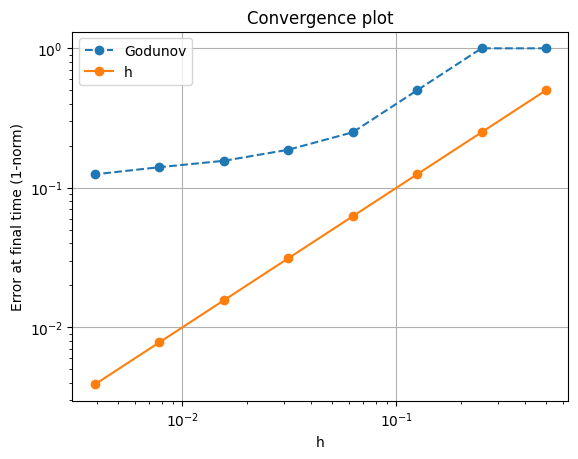

In [13]:
# Generate the convergence plot
plt.figure()
plt.loglog(h_val, errors, 'o--', label = 'Godunov')
plt.loglog(h_val, h_val, 'o-', label = 'h')

plt.xlabel('h')
plt.ylabel('Error at final time (1-norm)')
plt.title('Convergence plot')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
#Def for burgers equation


# mesh generator function
def mesh_generator_1d(x_l, x_r, n_nodes):
    h = (x_r - x_l) / (n_nodes - 1)
    x_coords = np.linspace(x_l, x_r, n_nodes)
    return h, x_coords

# initial condition function g(x)
def g(x):
    return np.where(x <= 0, 3, 3)

# exact solution function f(x, t)
def f_exact(x, t):
    return np.where(x <= 2*t, 3, 3)

# flux function for burgers
def flux(q):
    return np.power(q,2)/2




# Perform the convergence analysis
errors = []
h_val = []

T = 0.25     #final time
c = 2 #speed for burgers
x_r  = 1
x_l = -1


k_values = range(2, 10)
for k in k_values:
    n_nodes = 2 ** k + 1
    h, x = mesh_generator_1d(x_l, x_r, n_nodes)
    u, x_coords = godunov_solver(n_nodes, T)
    # Calculate the error as the 1-norm between u and the exact solution
    error = np.linalg.norm(u - f_exact(x_coords, T), ord=1)
    # h = (x_r - x_l) / (n_nodes - 1)
    errors.append(error*h)
    h_val.append(h)

# Display the errors
for i, error in enumerate(errors):
    print(f"Error for n_nodes={2 ** k_values[i] + 1}: {error}")


Error for n_nodes=5: 0.0
Error for n_nodes=9: 0.0
Error for n_nodes=17: 0.0
Error for n_nodes=33: 0.0
Error for n_nodes=65: 0.0
Error for n_nodes=129: 0.0
Error for n_nodes=257: 0.0
Error for n_nodes=513: 0.0
